In [1]:
!git clone https://github.com/Cajeux1999/AEMO-Solar-Energy-Forecasting.git -q

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

REPO_NAME = "AEMO-Solar-Energy-Forecasting"
%cd {REPO_NAME}

[Errno 2] No such file or directory: 'AEMO-Solar-Energy-Forecasting'
/content/AEMO-Solar-Energy-Forecasting


In [ ]:
#Importing the train_size defined in the config.py file, to generate the EDA study based on the training dataset
from src import config
train_size = config.TRAIN_SIZE

#Defining the filepath to load the dataset
filepath = '/content/AEMO-Solar-Energy-Forecasting/data/raw/'

In [4]:
#Importing New South Wales power output series
nsw1_solar = pd.read_csv(filepath+'nsw_solar.csv').drop(columns=['Unnamed: 0'])
nsw1_solar["ds"] = pd.to_datetime(nsw1_solar["ds"]).dt.tz_localize(None)

In [7]:
print(nsw1_solar[:train_size].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6133 entries, 0 to 6132
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         6133 non-null   datetime64[ns]
 1   y          6133 non-null   float64       
 2   unique_id  6133 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 143.9+ KB
None


In [8]:
print(nsw1_solar[:train_size].describe())

                        ds            y
count                 6133  6133.000000
mean   2024-09-02 21:00:00   689.060266
min    2024-07-01 00:00:00     0.003056
25%    2024-08-01 22:30:00     0.023056
50%    2024-09-02 21:00:00     1.589141
75%    2024-10-04 19:30:00  1475.992141
max    2024-11-05 18:00:00  3112.460053
std                    NaN   899.935415


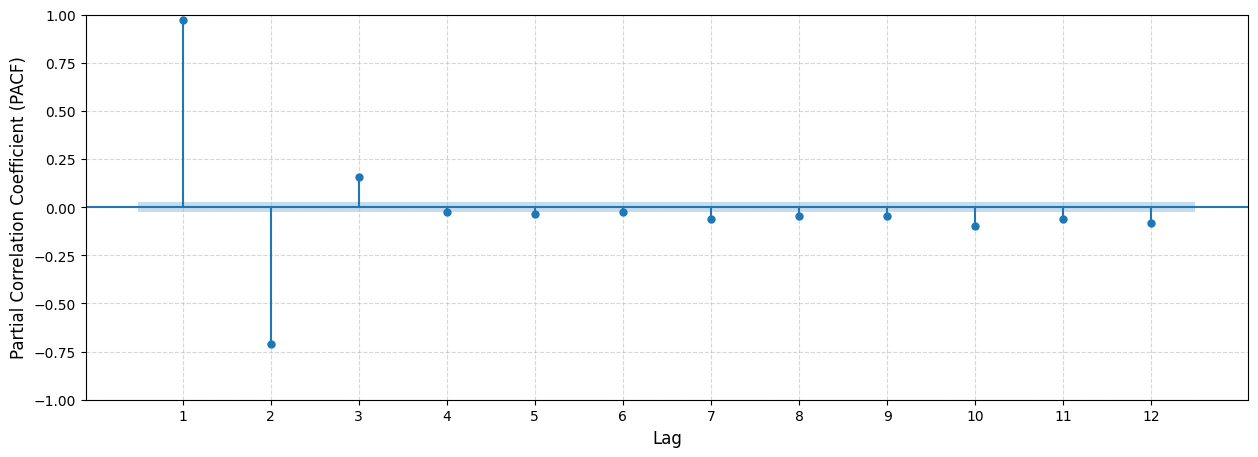

In [32]:
# Plotting PACF for 12 lags.
y = nsw1_solar[:train_size]["y"]

lags=12

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

plot_pacf(y, ax=ax, lags=range(1,13), zero=False)

ax.set_title("")
ax.set_xticks(range(1, lags + 1))

ax.set_ylabel("Partial Correlation Coefficient (PACF)", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

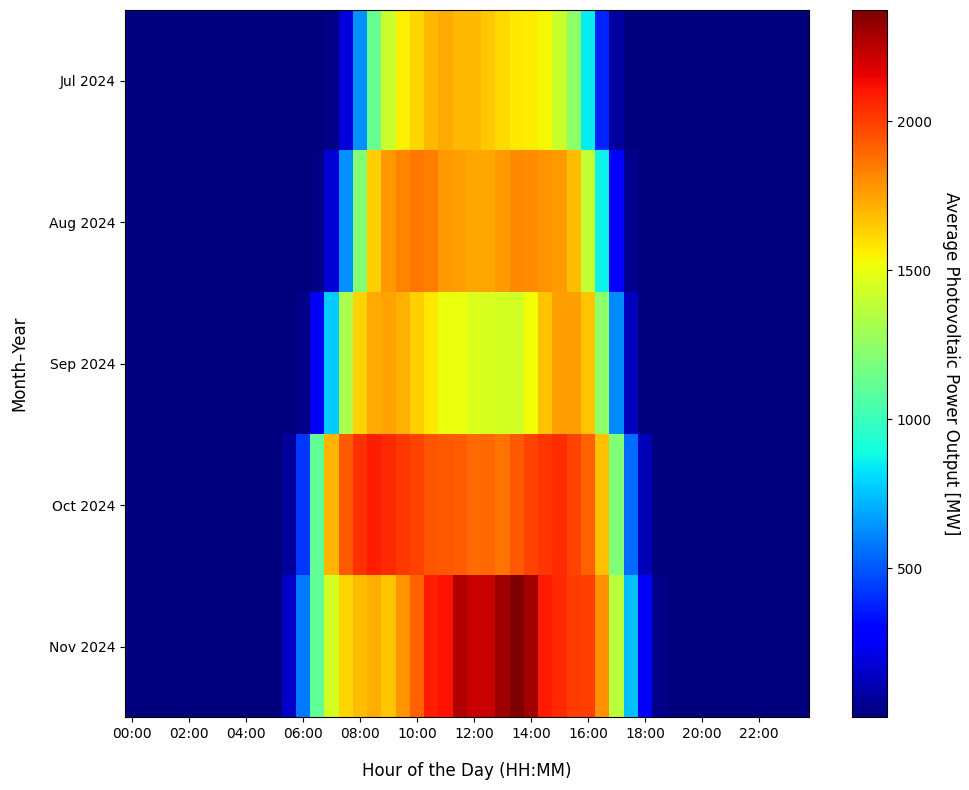

In [36]:
# Plotting a heatmap with the average generated power per hour.

heatmap = nsw1_solar[:train_size][['ds','y']].copy()

heatmap.index = pd.to_datetime(heatmap['ds'])
heatmap = heatmap.set_index('ds')

heatmap['time_of_day'] = heatmap.index.time
heatmap['date'] = heatmap.index.month.astype(str) + '-' + heatmap.index.year.astype(str)

heatmap_pivot = heatmap.pivot_table(
    index='date',
    columns='time_of_day',
    values='y',
    aggfunc='mean'
)

heatmap_pivot.index = pd.to_datetime(heatmap_pivot.index, format='%m-%Y')
heatmap_pivot = heatmap_pivot.sort_index(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(
    heatmap_pivot.values,
    aspect='auto',
    interpolation='none',
    cmap='jet'
)

num_cols = len(heatmap_pivot.columns)

tick_positions_x = np.arange(0, num_cols, 4)

tick_labels_x = [f'{(i // 4) * 2:02d}:00' for i in tick_positions_x]

ax.set_xticks(tick_positions_x)
ax.set_xticklabels(tick_labels_x)
ax.set_xlabel("Hour of the Day (HH:MM)", fontsize=12, labelpad=15)

data_labels = heatmap_pivot.index.astype(str)

month_starts = [i for i, date_str in enumerate(data_labels) if pd.to_datetime(date_str).day == 1]

tick_labels_y = [pd.to_datetime(data_labels[i]).strftime('%b %Y') for i in month_starts]

ax.set_yticks(month_starts)
ax.set_yticklabels(tick_labels_y)
ax.set_ylabel("Month–Year", fontsize=12, labelpad=15)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Average Photovoltaic Power Output [MW]', rotation=270, labelpad=20,fontsize=12)

ax.set_title('')
plt.tight_layout()
plt.show()